# Classification of Semiconductor Wafer Defects

Lukas Y. Peng, Iago Leal de Freitas

Professor David E. Bernal Neira

November 18, 2024



## 1. Introduction

The semiconductor industry is developing rapidly. Data science and machine learning techniques are being utilized to detect defetcs and to better control their processes in semiconductor manufacturing. In this project, a convolutional neural network model is rewritten in Python to detect and classify defects on wafers.

### 1.1. Background

In semiconductor manufacturing, a die is a small piece sliced from a silicon wafer. After circuit manufacturing processes such as CVD, PVD, lithography, etc., semiconductor wafers are diced into pieces containing each circuit. These small pieces are called **dies**.

However, in the semiconductor manufacturing process, even the smallest imperfections and impurities may interfere with the processes and cause die failure. Equipment malfunctions, chemical stains, or human failures etc. can all cause different failures. For example, scratches may be caused by machine handling, while center and edge-ring defects may be caused by etching problems and chemical deposition. These **failures** need to be identified to streamline the manufacturing process for efficiency.

To do so, wafers are tested and a **wafer bin map (WBM)** is produced to provide information on the quality and functionality of each die. A WBM displays which dies on a wafer has failed, while showing which ones are functional. In wafer map dataset experimented with in this project, a ternary numeral system represents 0 - non wafer pixel, 1 - functional wafer, and 2 - faulty wafer. In industrial practice, scientists and process engineers identify defects on wafer bin maps to manually sort defects on certain wafers and which defect classification (nine classes--further specified in *2.2 - Data Attributes*: no failure, near-full, edge-ring, loc, edge-loc, scratch, center, random, and donut). However, manually sorting defects is both inefficient and costly.

To recognize wafer defects more efficiently, various machine learning-based (ML) approaches have been developed. A github tutorial approaches the data set using ML-based models including **(1)-Support vector machine (SVM), (2)-Logistic regression (LR), and (3)-Random forest declassifier**. **Convolutional neural networks (CNNs)** have also been used to approach a more efficient classification process.

### 1.2. Objective

This project follows a CNN model as seen in MATLAB, which utilized MATLAB's image processing and deep learning toolboxes. This project follows the same overall steps to construct a CNN; however, the TensorFlow neural network model will be used in Python.

The process follows the following overall main steps:
1. Dataset Description
  - Source and Processing
  - Attributes
2. Preprocessing and Augmenting Data
  - Oversampling
  - Partitioning into Training and Testing
  - Resizing
3. Setting up the Network
  - Network layers
  - Network options
4. Analyzing the model
  - Confusion Matrix
  - Precision, Recall, and F1 scores
  - Precision-Recall curves

This project will analyze tensor flow results and compare them to the results ran by MATLAB scripts using its respective toolboxes. Additionally, results can show the differences between the ML-based models found by Xi Chen and Wu et. al.


## 2. Dataset Description



### 2.1. Data Source

The experiment is conducted using the real-time wafer map dataset WM-811K. The data is available on Kaggle: https://www.kaggle.com/qingyi/wm811k-wafer-map. This is a public dataset from the Multimedia Information Retrieval (MIR) lab (http://mirlab.org/dataset/public/).

This dataset contains 811,457 wafer maps collected from 46,393 lots in real-world fabrication. The dataset includes nine regular wafer map failure pattern types: Center, Donut, Local, Edge-Local, Edge-Ring, Scratch, Random, Near-Full, and None.


### 2.2. Data Attributes

The data set comes as a dataframe with 811457 entries and 6 total columns. These aspects of each WBM include: *waferMap* - a pixel by pixel 2D array that represents the WBM; *dieSize* - irrelevant measurement of how big the WBM is; *lotName* - lot containing said WBM; *waferIndex* - a WBM's entry in its respective lot; *trainTestLabel* - labels WBM as either training or testing data; and *failureType* - none for no failure and either of the other 8 failure classifications.

In [6]:
# Read data file

import pandas as pd
#{Following code block is for Google Colab use
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/LSWMD.pkl'
df_init = pd.read_pickle(file_path)
df_init.info()
#}

#If dataframe is saved locally:
#import pandas as pd
#df = pd.read_pickle("./data/LSWMD.pkl")
#df.info()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import random

# display dataframe format and categories
df_init.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


The waferMap column contains the wafer bin map, pixel by pixel. For simplicity, each die on the WBM is considered failed if it fails for at least one test, and otherwise it is considered functional. If a die on a wafer fails, it is marked as 2 or it is marked 1 if it passes. Therefore, each pixels has a categorical variable that expresses
- 0 : not wafer
- 1 : normal
- 2 : faulty

Identifying wafer defects requires only the waferMap and its failureType. Thus, we can drop the other four WBM attributes without affecting the data analysis.

In [7]:
# Correct columns & remove unnecessary information
df = df_init.copy()
df = df.drop(['waferIndex'], axis = 1)
df = df.drop(['lotName'], axis = 1)
df = df.drop(['dieSize'], axis = 1)
df = df.drop(['trianTestLabel'], axis = 1)
df.head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[none]]


For the WBMs that have no failureType label, we can replace failureType for those with an empty value, later removing them from the dataset. Now, we can see the data distribution of our failureTypes as shown below. Making the dataframe categorical is easier to separate and show data distribution.

In [8]:
# Create a copy of dataset

df2 = df.copy()
df2.failureType = df2.failureType.apply(lambda x: x[0][0] if len(x) > 0 else float("NaN"))
df2['failureType'] = df2['failureType'].astype('category')

# Check falure type distribution
# Check failure type distribution of wafers with non-null labels

df2['failureType'].value_counts()
#df2['failureType'].value_counts(dropna = False, normalize = True).plot.pie()
#df2['failureType'].value_counts().plot.bar()
#df2['failureType'].value_counts().sum()
# There are 172950 (sum)
# df2.shape[0] -> 811457

,count
failureType,
none,147431
Edge-Ring,9680
Edge-Loc,5189
Center,4294
Loc,3593
Scratch,1193
Random,866
Donut,555
Near-full,149


We can also see that out of the entire dataset, only 172,950 images with manual labels (in total 9 labels: none, Edge-Ring, Edge-Loc, Center, Loc, Scratch, Random, Donut, and Near-full). 78.7% wafers have no label based on the failureType attribute. Among labeled wafers, only ~15% wafers (25,519 wafers) have real failure patterns while 147,431 wafers were still labeled none.

As the MATLAB distribution does not remove any data to cancel out any potential noise or bias from the analysis, we won't as well. Below, the empty failureTypes which make up a large portion of the dataframe are removed. Additionally, a numeric failureNum is mapped to the preexisting failureType column to fit tensor flow categorical requirements.

**Note**: It should be noted that the Python tutorial using SVM, LR, and RFC by Xi Chen continues to remove near-full failureTypes as it does not make up more than 1% of the data set. Additionally, smaller data sets not making up larger than 5,5 dimensions are removed (this is only about 2 WBMs).

In [9]:
# Delete unlabeled data (and "near-full" type)

df2['failureNum'] = df2.failureType
mapping_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}

df2 = df2.replace({'failureNum':mapping_type}).infer_objects(copy=False)
df2['failureNum'] = pd.to_numeric(df2['failureNum'], errors='coerce')

df2 = df2[(df2['failureNum']>=0) & (df2['failureNum']<=8)]

# removes 149 occasions. shown above ^
#df2 = df2[(df2['failureType']!='Near-full')]

df2['failureType'] = df2['failureType'].cat.remove_unused_categories()

# Filter out filter maps that are too small
# size_filter = [all(np.greater(df2['waferMapDim'].iloc[i], (5,5))) for i in range(len(df2))]
# df2 = df2[size_filter]
df2.shape[0]

<ipython-input-9-487df7ad23ed>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2 = df2.replace({'failureNum':mapping_type}).infer_objects(copy=False)
<ipython-input-9-487df7ad23ed>:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df2 = df2.replace({'failureNum':mapping_type}).infer_objects(copy=False)


172950

We will visualize the some wafer bin maps to see what the failure patterns look like. The dark purple region is the region that is not a wafer, the green color in the figure denotes that the die on the wafer has passed, while yellow denotes that the die has failed. This gives us a visual idea of what each failureType may look like on their WBMs.

**Center** - There is a small, dense bloc in the middle of the wafer that contains failing dies.

**Donut** - A ring, either thin like a small line or thicker like the shape of a donut consisting of failing dies surrounds the middle of the wafer.

**Edge-Loc** - A region of faulty dies lying on the edge of the wafer, either spread out like a crescent or collected like a bloc.

**Edge-Ring**: A small thin etched line forming an outer ring of faulty dies.

**Loc**: An area of connected faulty dies, neither on the edge or the center of the wafer.

**Near-full**: Almost all dies are faulty

**Random**: No clear pattern of faulty dies; however, faulty dies still make up a majority of the WBM.

**Scratch**: A thin line running from one edge to edge like a thin, hair-sized line of faulty dies.

**none**: Mostly performing correctly with no regional pattern of faulty dies.

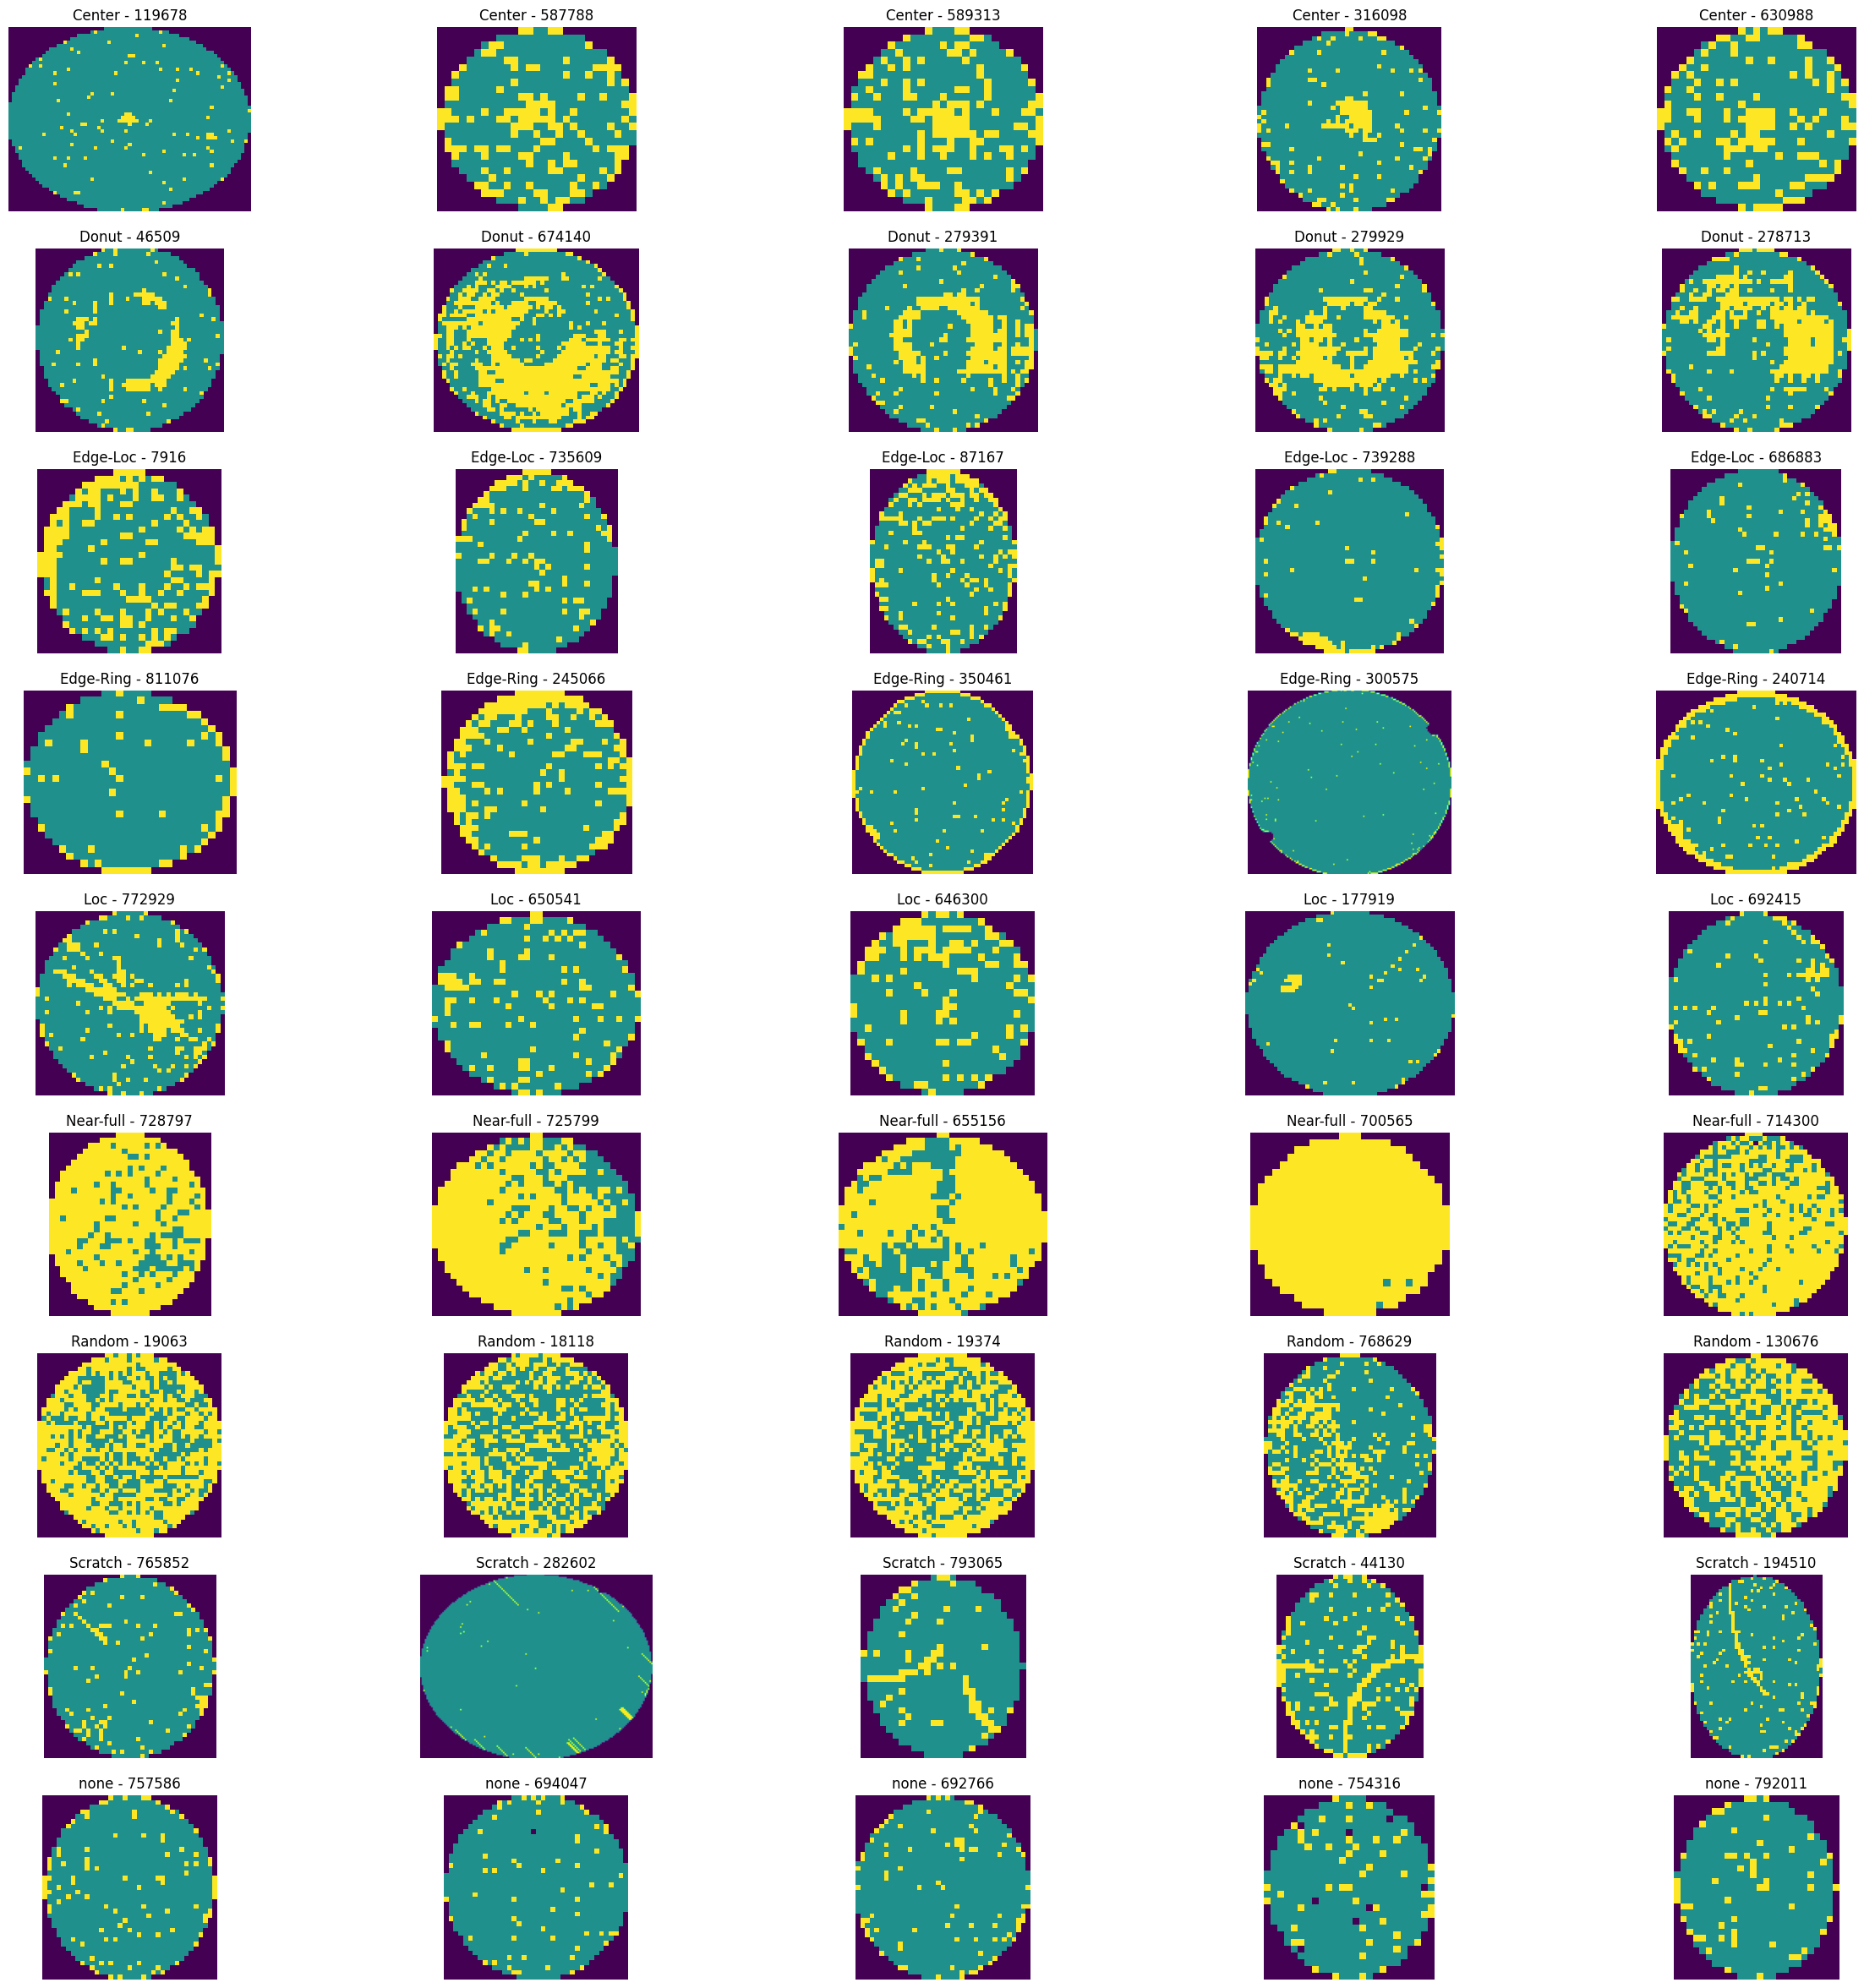

In [11]:
# Plot each failure type as examples
sample_size = 5
failure_types = list(df2['failureType'].cat.categories)
num_cat = len(failure_types)
fig, axs = plt.subplots(num_cat, sample_size, figsize = (30,30))
for i_cat in range(num_cat):
    cat = failure_types[i_cat]
    random.seed(10)
    sample = df2.loc[df2['failureType'] == cat].sample(sample_size)
    for i in range(len(sample)):
        index = sample.index[i]
        axs[i_cat, i].axis('off')
        axs[i_cat, i].imshow(sample['waferMap'][index])
        axs[i_cat, i].set_title(f'{cat} - {index}')

The figure above shows 5 random examples of each of the eight wafer map failure types.

## 3. Preprocess and Augment Data


### 3.1 Balance Data by Oversampling

The data distribution, as seen in 2.1 is heavily unbalanced. There are significantly fewer images in defect classes as there are with no defects. A CNN model may then overbias towards no defects. An effort to combat this is to oversample data so that there are a relatively larger number of each defect class image.

To improve class balancing, an oversample function is written to cycle through every defect class (not being none) and is duplicated and appended to the existing dataframe. The oversample function appends the dataframe with 5 modified copies of each defect image with the following modifications: horizontal reflection, vertical reflection, or rotation by a multiple of 90 degrees.

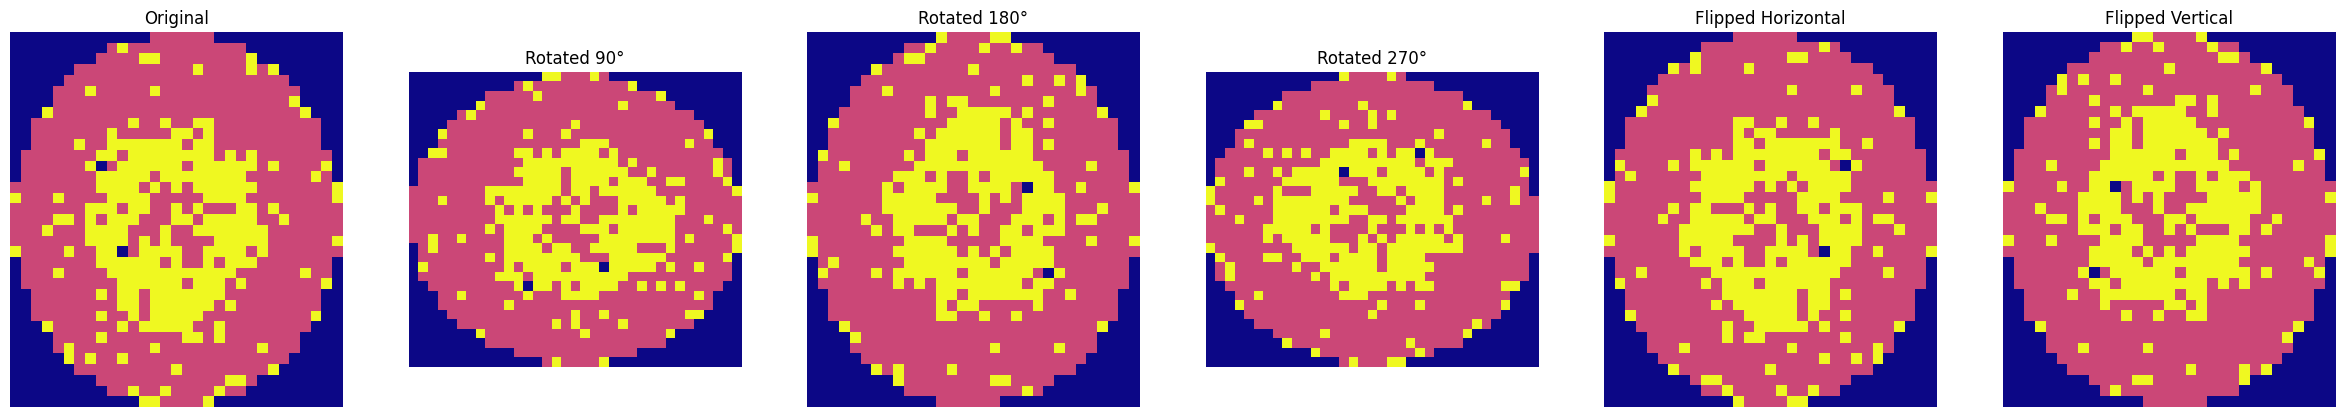

failureType
none         147431
Edge-Ring     58080
Edge-Loc      31134
Center        25764
Loc           21558
Scratch        7158
Random         5196
Donut          3330
Near-full       894
Name: count, dtype: int64


In [12]:
import random

df3 = df2.copy()

def oversample(df):
    # Create an empty list to store the augmented data
    augmented_data = []
    valid_df = df[df['failureType'] != 'none']
    sample = random.choice(valid_df.index)

    for index, row in valid_df.iterrows():
        wafer_map = row['waferMap']
        rotated_90 = np.rot90(wafer_map)
        rotated_180 = np.rot90(wafer_map, 2)
        rotated_270 = np.rot90(wafer_map, 3)
        flipped_horizontal = np.fliplr(wafer_map)
        flipped_vertical = np.flipud(wafer_map)

        augmented_data.append({'waferMap': rotated_90, 'failureType': row['failureType'], 'failureNum': row['failureNum']})
        augmented_data.append({'waferMap': rotated_180, 'failureType': row['failureType'], 'failureNum': row['failureNum']})
        augmented_data.append({'waferMap': rotated_270, 'failureType': row['failureType'], 'failureNum': row['failureNum']})
        augmented_data.append({'waferMap': flipped_horizontal, 'failureType': row['failureType'], 'failureNum': row['failureNum']})
        augmented_data.append({'waferMap': flipped_vertical, 'failureType': row['failureType'], 'failureNum': row['failureNum']})

        if index==sample:
            fig, axs = plt.subplots(1, 6, figsize=(30,30))
            axs[0].imshow(wafer_map, cmap='plasma')
            axs[0].set_title("Original")
            axs[1].imshow(rotated_90, cmap='plasma')
            axs[1].set_title("Rotated 90°")
            axs[2].imshow(rotated_180, cmap='plasma')
            axs[2].set_title("Rotated 180°")
            axs[3].imshow(rotated_270, cmap='plasma')
            axs[3].set_title("Rotated 270°")
            axs[4].imshow(flipped_horizontal, cmap='plasma')
            axs[4].set_title("Flipped Horizontal")
            axs[5].imshow(flipped_vertical, cmap='plasma')
            axs[5].set_title("Flipped Vertical")
            for ax in axs:
                ax.axis('off')
            plt.show()

    # Add augmented sample to original df
    augmented_df = pd.DataFrame(augmented_data)
    oversampled_df = pd.concat([df, augmented_df], ignore_index=True)

    return oversampled_df

df3 = oversample(df3)
print(df3.failureType.value_counts())

A random defect class is gathered and displayed as to how the oversample function modifies it into 5 modified copies.

Additionally from the value_counts() summary showing the distribution of each failureType, we can see that each defect class has been increased by 6 times its original. Although they are still relatively small compared to the no defect class, the percentage of no defects goes from 85.2% "none" failureType distribution to 49.1%, reducing the class biasing to "none" by a large factor.

### 3.2 Partition Data into Testing, Validation, and Training

Split the oversampled data set into training, validation, and test sets using the splitlabels function. Approximately 90% of the data is used for training, 5% is used for validation, and 5% is used for testing.

In [ ]:
from sklearn.model_selection import train_test_split

X = df3['waferMap'].values
y = df3['failureNum'].values

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

Training target statistics: Counter({8.0: 110497, 3.0: 43488, 2.0: 23384, 0.0: 19343, 4.0: 16210, 6.0: 5415, 5.0: 3920, 1.0: 2492, 7.0: 659})
Testing target statistics: Counter({8.0: 36934, 3.0: 14592, 2.0: 7750, 0.0: 6421, 4.0: 5348, 6.0: 1743, 5.0: 1276, 1.0: 838, 7.0: 235})


### 3.3 Resize Training Data

Resize training data to fit so there is no overfitting bias when CNN is applied.

In [ ]:
import cv2
def resize_images(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (48, 48))
        resized_images.append(resized_image)
    return np.array(resized_images)

X_train_resized = resize_images(X_train)
X_test_resized = resize_images(X_test)

## 4. Create Network

Convolutional neural networks, put simply, use kernels, matrices of smaller values and sizes, to iterate through an image to detect patterns for certain classifications. This is most commonly applicable to image processing and image detection as a CNN can detect patterns and features in its area around it.

Each CNN layer is consisted of convolutional layer, a nonlinearity layer, in this case a ReLU, and lastly a max pooling.



### 4.1 Create Network Architecture

Tensorflow is a popular machine learning model to construct neural network models. For image processing, convolutional neural networks are especially useful training a model that can accurately predict wafer defects.

Below, a tensorflow model with a CNN architecture based on the MATLAB model is produced. Three layers are applied to the wafer maps.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input shape and number of classes
num_classes = 9  # Replace with the actual number of classes

# Build the model
model = models.Sequential([
    # Input layer with normalization
    layers.Rescaling(1/2, input_shape=(48, 48, 1)),  # Normalization from 0 to 2

    # First convolutional block
    layers.Conv2D(8, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Second convolutional block
    layers.Conv2D(16, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Third convolutional block
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Fourth convolutional block
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),

    # Dropout layer
    layers.Dropout(0.5),  # Adjust dropout rate if needed

    # Fully connected layer
    layers.Flatten(),
    layers.Dense(num_classes),
    layers.Softmax()
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 48, 48, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9)                   │          20,745 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 45,609 (178.16 KB)

 Trainable params: 45,369 (177.22 KB)

 Non-trainable params: 240 (960.00 B)

### 4.2 Define Training Options

Based on the MATLAB model, we will use Adam optimization and training the network for 30 epochs.

In [ ]:
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

X_train_tf = tf.convert_to_tensor(X_train_resized, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test_resized, dtype=tf.float32)

history = model.fit(
    X_train_tf, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test_tf, y_test),
    shuffle=True,
    verbose=0  # Set to 1 for detailed output, 0 to suppress output
)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


## 5. Quantifying Network Performance


### 5.1 Validation and Training Loss

The following code shows validation and training loss per epoch of training this network. Both training and validation begin to converge to a higher accuracy.

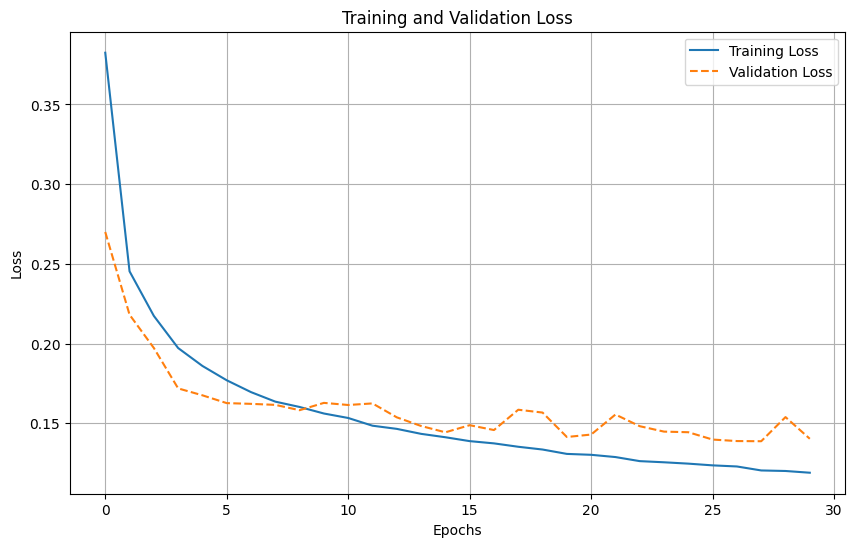

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

### 5.2 Confusion Matrix

A confusion matrix can help analyze what features are harder for this model to predict as well as compare how well each defect class is being identified.

2349/2349 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


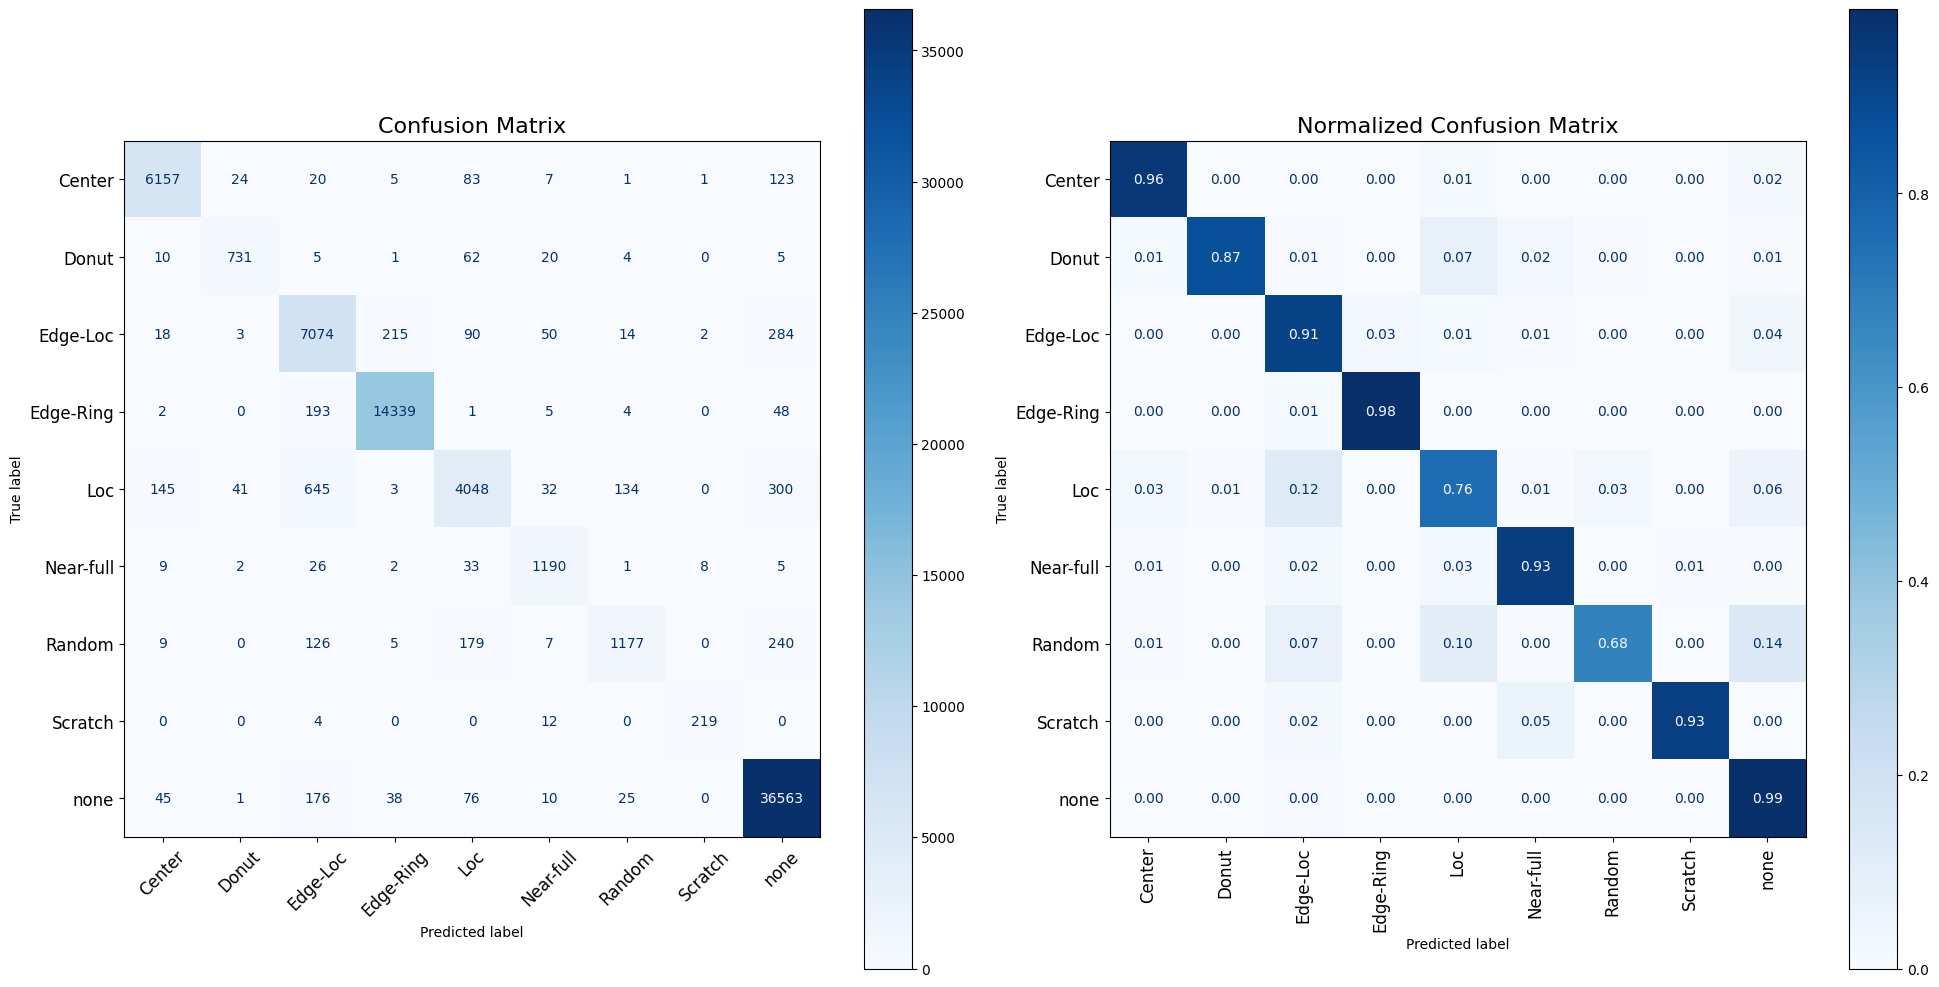

In [ ]:
y_pred = np.argmax(model.predict(X_test_tf), axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Plot the standard confusion matrix on the first subplot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=failure_types)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=axes[0])  # Plot on the first subplot (axes[0])
axes[0].set_title('Confusion Matrix', fontsize=16)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Plot the normalized confusion matrix on the second subplot
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=failure_types)
disp_normalized.plot(include_values=True, cmap=plt.cm.Blues, values_format='.2f', ax=axes[1], xticks_rotation='vertical')  # Plot on the second subplot (axes[1])
axes[1].set_title('Normalized Confusion Matrix', fontsize=16)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In the confusion matrices produced we can deduce a couple things. As seen in *2.2 - Data Attributes*, a couple of the defects are more difficult, even for manual identification, to classify. The lower accuracy classes as shown in the normalized confusion matrix, include loc, random, and donut defect classes. Viewing the sample defect WBMs showin *2.2*, we see that its hard to differentiate. However, it is interesting that the random defect class is harder to identify using this tensorflow model.

In the MATLAB model mentioned earlier, a confusion matrix shows that some other defect classes such as the scratch are far less accurate; however, in this model, they seem to predict those a little better.

**Note**: It is also shown in the model using SVM in Xi Chen's previous Python tutorial, that the identification of loc and edge-loc defect classes are also lower relative to other defect classes.

### 5.3 Precision-Recall Curves

We can also evaluate network performance using precision, recall, and F1 scores.

Definitions:
- **True positive**: images predicted as a class and actually belonging to that class
- **False positive**: those predicted to belonging to one class while it actually belongs to another
- **False negative**: fails to predict a wafer is defective when it is actually defective

Precision is the proportion of images that are correctly predicted to belong to a class, and gives the ratio of true positive to total positive predictions made by the model:
\begin{align}
        \text{Precision: } = \frac{TP}{TP+FP}.
    \end{align}

Recall is the ratio of true positives to the sum of true positives false negatives. It represents the proporiton of true positives out of all actual positive cases.
\begin{align}
        \text{Recall: } = \frac{TP}{TP+FN}.
    \end{align}

F1 scores are the harmonic mean of the precision and recall values as given by:
\begin{align}
        \text{F1: } = \frac{2\times\text{precision}\times\text{recall}}{(\text{precision+recall})}.
    \end{align}

In [ ]:
import pandas as pd

# Initialize parameters
pr_table = pd.DataFrame(index=failure_types, columns=["Recall", "Precision", "F1"])

# Calculate Precision, Recall, and F1 score for each class
for idx in range(num_classes):
    # True Positives (TP), False Positives (FP), and False Negatives (FN)
    num_tp = cm[idx, idx]
    num_fp = sum(cm[:, idx]) - num_tp
    num_fn = sum(cm[idx, :]) - num_tp

    # Calculate precision and recall, handling division by zero
    precision = num_tp / (num_tp + num_fp) if (num_tp + num_fp) > 0 else 0.0
    recall = num_tp / (num_tp + num_fn) if (num_tp + num_fn) > 0 else 0.0

    # Calculate F1 score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Store the values in the table
    pr_table.loc[failure_types[idx], "Recall"] = recall
    pr_table.loc[failure_types[idx], "Precision"] = precision
    pr_table.loc[failure_types[idx], "F1"] = f1_score

# Display the Precision-Recall table
print(pr_table)

             Recall Precision        F1
Center     0.958885  0.962783   0.96083
Donut      0.872315  0.911471  0.891463
Edge-Loc   0.912774  0.855484  0.883201
Edge-Ring  0.982662  0.981585  0.982123
Loc        0.756918  0.885389  0.816129
Near-full  0.932602  0.892723  0.912227
Random     0.675273  0.865441  0.758621
Scratch    0.931915  0.952174  0.941935
none       0.989955  0.973249  0.981531


Given above is the recall, precision, and F1 scores of each defect class. We can further analyze that Loc defect classification is not precise. When it does identify a loc, it gets it wrong about 24.4% of the time. A random classification is also not as precise as the others, only getting a prediction correct 67.5% of the time. However, compared to the MATLAB model, the F1 scores are on average higher.

Below, precision-recall curves are plotted. Precision-recall curves are used to understand a model's ability to identify true positives (reflected by recall) while avoiding false positives (reflected by precision).

2349/2349 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


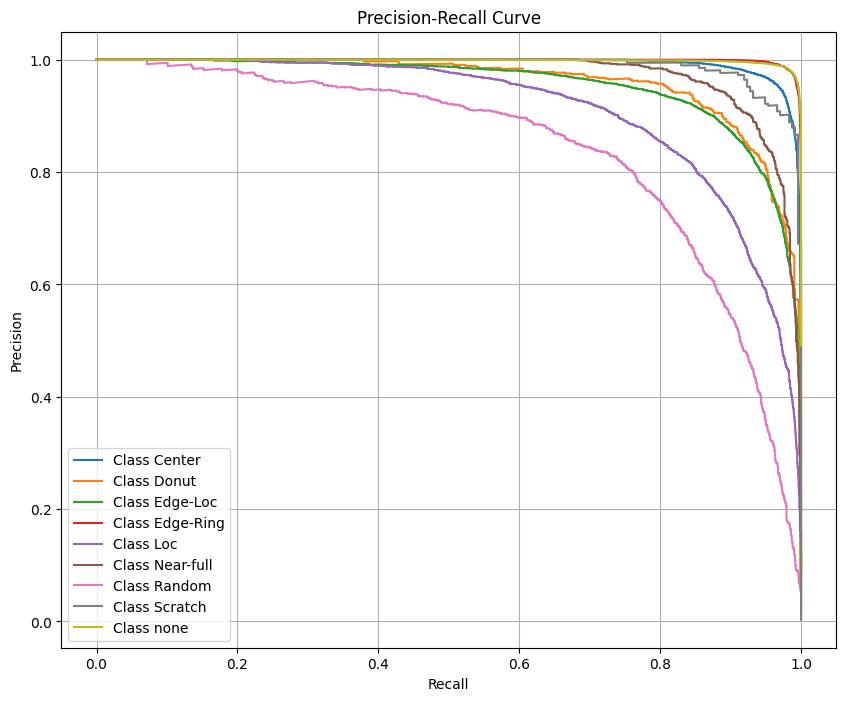

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Predict probabilities for each class
y_score = model.predict(X_test_tf)

# Calculate precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'Class {failure_types[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Ideally, the precision-recall cruve should be steep and tend toward (1, 1), such as Center and edge-ring. Those that perform the best in predicting classes tend toward a steeper curve passing through (1, 1), while those that are worse performing such as Random and Loc in this model are less steep and tend toward the diagonal from (0, 1) to (1, 0).

Compared to the PR curves produced by the MATLAB model, the predictions for scratch are much higher while those for random are far worse. However, overall the tensorflow model performed better as the F1 scores suggested.

## 6. Conclusions

Wafer defects offer a lot of insight on which step of the semiconductor manufacturing process an error may have occured on. Additionally, training models to an open-source programming platform like Python offers variability and easy tuning for compatible industrial practice. This suggests applications in collaboration utillizing quatum federated learning projects.

In this project, we developed a defect pattern classification method using a convolutional neural network model using the tensorflow software based on a MATLAB model. We achieved results that suggest that this model is better at predicting wafer defects than its MATLAB counterpart. This yields two great advantages, as previously mentioned:

1. For future industrial practices, implementation of quick semiconductor wafer defects can quickly and reliably detect wafer defects and suggest where manufacturing mishaps may have occured.
2. Creates a larger open source platform that can be accessible to a larger network.

## References

Wu, Ming-Ju, Jyh-Shing R. Jang, and Jui-Long Chen. “Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets.” IEEE Transactions on Semiconductor Manufacturing 28, no. 1 (February 2015): 1–12. https://doi.org/10.1109/TSM.2014.2364237.

https://www.mathworks.com/help/vision/ug/classify-defects-on-wafer-maps-using-deep-learning.html

https://github.com/iamxichen/Semiconductor-Wafer-Defect-Classification/blob/main/Semiconductor%20Wafer%20Defect%20Classification.ipynb

https://www.tensorflow.org/tutorials/images/cnn

http://mirlab.org/dataSet/public/